## Set-up

In [93]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
from tqdm.notebook import tqdm, trange

sns.set_theme()
colors = sns.color_palette("deep")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utils import geometric_median, geometric_medoid

In [94]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [95]:
def initialize_W(X, n_components):
    W = pd.DataFrame(np.random.rand(len(X), n_components), index=X.index, columns=[f"Component {k+1}" for k in range(n_components)])
    W = W.div(W.sum(axis=1), axis=0)
    return W

In [247]:
n_components = 3 # Number of components for the matrix factorization
n_runs = 1000
smoothed = True

colormap = ListedColormap([colors[k] for k in range(n_components)])

# Process data

## Data matrix $X$

In [248]:
input_df = pd.read_csv('data/daily_curves_pos_smoothed_13b_15min.csv', index_col=0)
print(len(input_df))
input_df.head(3)

11646


0        0.25         0.5  \
Calabria_2021-01-02_Saturday     540.368002  531.208491  522.248983   
Calabria_2021-01-03_Holiday      531.304293  513.467409  496.986069   
Calabria_2021-01-04_Working day  565.808069  535.927061  508.320522   

                                       0.75           1        1.25  \
Calabria_2021-01-02_Saturday     513.195836  503.907120  494.407420   
Calabria_2021-01-03_Holiday      481.788689  467.790162  454.927252   
Calabria_2021-01-04_Working day  483.912223  463.313033  446.814986   

                                        1.5        1.75           2  \
Calabria_2021-01-02_Saturday     484.876178  475.612497  466.984142   
Calabria_2021-01-03_Holiday      443.184309  432.605824  423.294708   
Calabria_2021-01-04_Working day  434.421343  425.893771  420.804605   

                                       2.25  ...       21.75          22  \
Calabria_2021-01-02_Saturday     459.370813  ...  689.571536  665.976134   
Calabria_2021-01-03_Holiday      415.397675  ...  721.303968  702.586994   
Calabria_2021-01-04_Working day  418.590289  ...  779.939601  763.771632   

                                      22.25        22.5       22.75  \
Calabria_2021-01-02_Saturday     643.493085  622.725045  604.049124   
Calabria_2021-01-03_Holiday      682.122531  660.347200  637.800513   
Calabria_2021-01-04_Working day  747.037136  728.650968  707.735993   

                                         23       23.25        23.5  \
Calabria_2021-01-02_Saturday     587.609571  573.334412  560.970758   
Calabria_2021-01-03_Holiday      615.055183  592.648384  571.027045   
Calabria_2021-01-04_Working day  683.810367  656.903194  627.567748   

                                      23.75          24  
Calabria_2021-01-02_Saturday     550.134156  540.368002  
Calabria_2021-01-03_Holiday      550.515032  531.304293  
Calabria_2021-01-04_Working day  596.788303  565.808069  

[3 rows x 97 columns]

In [249]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11646


0        0.25         0.5  \
Calabria_2021-01-02_Saturday     540.368002  531.208491  522.248983   
Calabria_2021-01-03_Holiday      531.304293  513.467409  496.986069   
Calabria_2021-01-04_Working day  565.808069  535.927061  508.320522   

                                       0.75           1        1.25  \
Calabria_2021-01-02_Saturday     513.195836  503.907120  494.407420   
Calabria_2021-01-03_Holiday      481.788689  467.790162  454.927252   
Calabria_2021-01-04_Working day  483.912223  463.313033  446.814986   

                                        1.5        1.75           2  \
Calabria_2021-01-02_Saturday     484.876178  475.612497  466.984142   
Calabria_2021-01-03_Holiday      443.184309  432.605824  423.294708   
Calabria_2021-01-04_Working day  434.421343  425.893771  420.804605   

                                       2.25  ...       22.75          23  \
Calabria_2021-01-02_Saturday     459.370813  ...  604.049124  587.609571   
Calabria_2021-01-03_Holiday      415.397675  ...  637.800513  615.055183   
Calabria_2021-01-04_Working day  418.590289  ...  707.735993  683.810367   

                                      23.25        23.5       23.75  \
Calabria_2021-01-02_Saturday     573.334412  560.970758  550.134156   
Calabria_2021-01-03_Holiday      592.648384  571.027045  550.515032   
Calabria_2021-01-04_Working day  656.903194  627.567748  596.788303   

                                         24    region  year  month  \
Calabria_2021-01-02_Saturday     540.368002  Calabria  2021     01   
Calabria_2021-01-03_Holiday      531.304293  Calabria  2021     01   
Calabria_2021-01-04_Working day  565.808069  Calabria  2021     01   

                                     daytype  
Calabria_2021-01-02_Saturday        Saturday  
Calabria_2021-01-03_Holiday          Holiday  
Calabria_2021-01-04_Working day  Working day  

[3 rows x 101 columns]

In [250]:
X = df.drop(unit_info.columns, axis=1)
# We want to keep a functional l1 norm of 1. In case of 15min interval load measures (so 97 measures), we normalise by the l1 norm of the vector divided by int(97 / 24) = 4
X = X.div(X.sum(axis=1), axis=0) * int(X.shape[1] / 24)
X.head()

0      0.25       0.5      0.75  \
Calabria_2021-01-02_Saturday     0.035871  0.035263  0.034668  0.034067   
Calabria_2021-01-03_Holiday      0.035352  0.034165  0.033069  0.032058   
Calabria_2021-01-04_Working day  0.032210  0.030509  0.028938  0.027548   
Calabria_2021-01-05_Working day  0.032491  0.032137  0.031872  0.031662   
Calabria_2021-01-06_Holiday      0.034266  0.033075  0.031992  0.031028   

                                        1      1.25       1.5      1.75  \
Calabria_2021-01-02_Saturday     0.033451  0.032820  0.032187  0.031573   
Calabria_2021-01-03_Holiday      0.031126  0.030270  0.029489  0.028785   
Calabria_2021-01-04_Working day  0.026375  0.025436  0.024731  0.024245   
Calabria_2021-01-05_Working day  0.031471  0.031267  0.031028  0.030740   
Calabria_2021-01-06_Holiday      0.030187  0.029468  0.028869  0.028385   

                                        2      2.25  ...     21.75        22  \
Calabria_2021-01-02_Saturday     0.031000  0.030494  ...  0.045776  0.044209   
Calabria_2021-01-03_Holiday      0.028166  0.027640  ...  0.047995  0.046749   
Calabria_2021-01-04_Working day  0.023955  0.023829  ...  0.044400  0.043480   
Calabria_2021-01-05_Working day  0.030403  0.030031  ...  0.041669  0.040267   
Calabria_2021-01-06_Holiday      0.028011  0.027743  ...  0.045544  0.044590   

                                    22.25      22.5     22.75        23  \
Calabria_2021-01-02_Saturday     0.042717  0.041338  0.040098  0.039007   
Calabria_2021-01-03_Holiday      0.045388  0.043939  0.042438  0.040925   
Calabria_2021-01-04_Working day  0.042527  0.041480  0.040290  0.038928   
Calabria_2021-01-05_Working day  0.038891  0.037580  0.036369  0.035287   
Calabria_2021-01-06_Holiday      0.043515  0.042325  0.041037  0.039680   

                                    23.25      23.5     23.75        24  
Calabria_2021-01-02_Saturday     0.038060  0.037239  0.036519  0.035871  
Calabria_2021-01-03_Holiday      0.039434  0.037995  0.036631  0.035352  
Calabria_2021-01-04_Working day  0.037396  0.035726  0.033974  0.032210  
Calabria_2021-01-05_Working day  0.034356  0.033582  0.032965  0.032491  
Calabria_2021-01-06_Holiday      0.038288  0.036899  0.035548  0.034266  

[5 rows x 97 columns]

# NMF

In [251]:
p = len(X.columns)

In [252]:
# Load the arrays from the .npz file
if smoothed:
    path = f'data/nmf_results/batch/{n_components}comp_smoothed_{n_runs}runs.npz'
else:  
    path = f'data/nmf_results/batch/{n_components}comp_{n_runs}runs.npz'
data = np.load(path)
print('Loaded ', path)

Loaded  data/nmf_results/batch/3comp_smoothed_1000runs.npz


In [253]:
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
errors = data['errors']

## Clean results

In [254]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
H_results = H_results[..., iterations > 100]
W_results = W_results[..., iterations > 100]
errors = errors[iterations > 100]
iterations = iterations[iterations > 100]
print('{} results clean'.format(W_results.shape[2]))

342 results clean


# Results analysis

## K-means clustering to group similar profiles

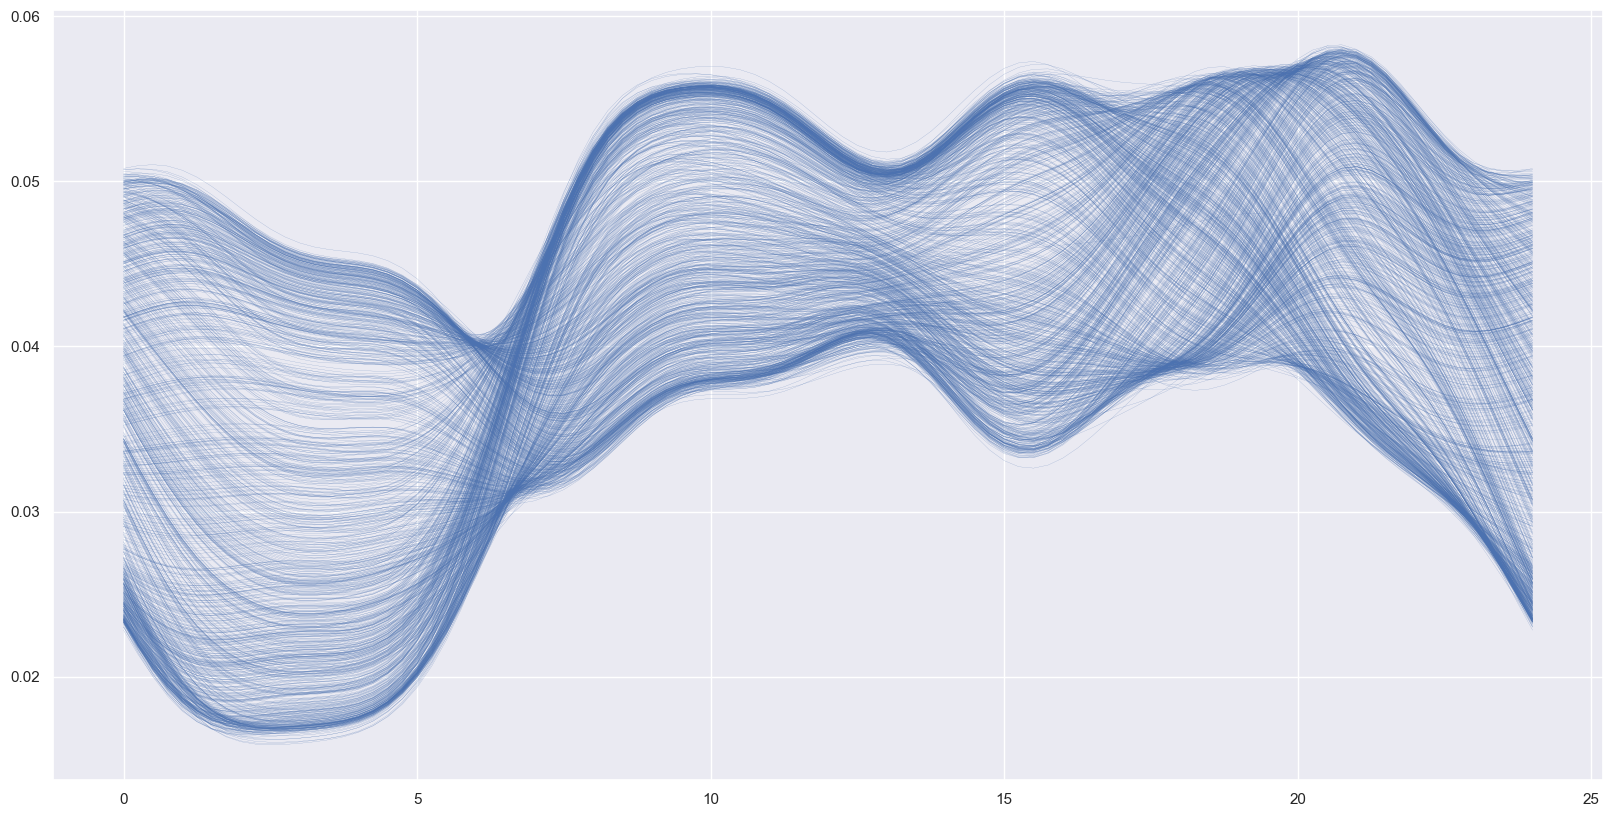

In [255]:
n_clean_runs = W_results.shape[2]
abscissa = [float(x) for x in X.columns]
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(n_clean_runs):
    for k in range(n_components):
        line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[0])

In [256]:
H_results_flat = H_results.transpose([0, 2, 1]).reshape((n_components * n_clean_runs, p)) # Flattening the array of profiles
kmeans = KMeans(n_clusters=n_components, n_init=10).fit(H_results_flat)

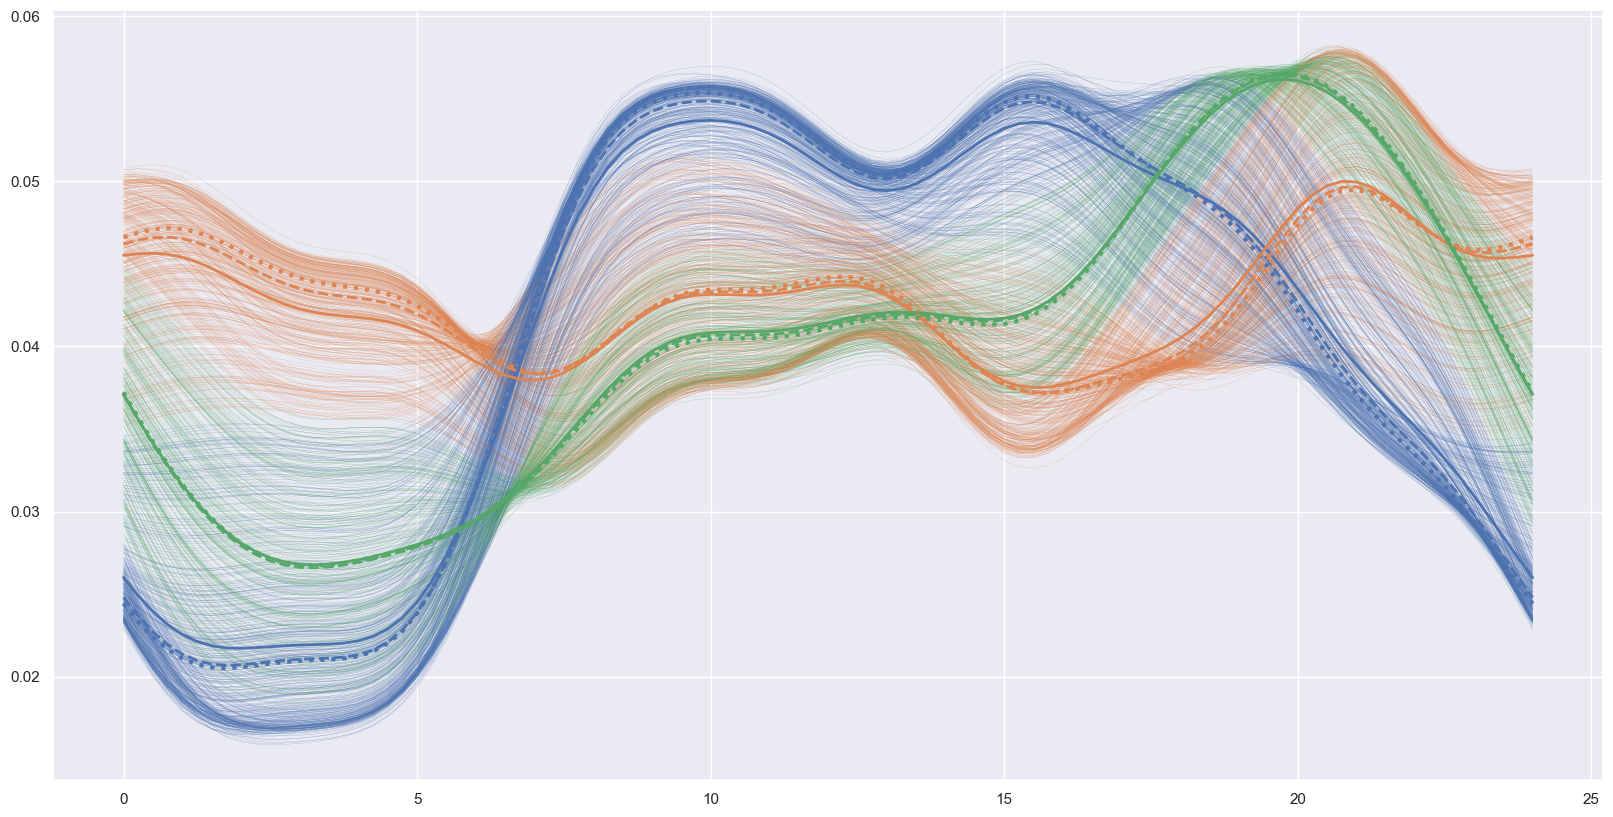

In [257]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    ax.plot(abscissa, H_results_flat[i, :], linewidth=0.1, color=colors[cluster_label])

# Plot cluster centroids
for i in range(n_components):
    ax.plot(abscissa, kmeans.cluster_centers_[i, :], linewidth=2, color=colors[i])
    ax.plot(abscissa, geometric_median(H_results_flat[kmeans.labels_ == i, :]), linewidth=2, linestyle='dashed', color=colors[i])
    ax.plot(abscissa, geometric_medoid(H_results_flat[kmeans.labels_ == i, :]), linewidth=3, linestyle='dotted', color=colors[i])
    

Let's plot per cluster

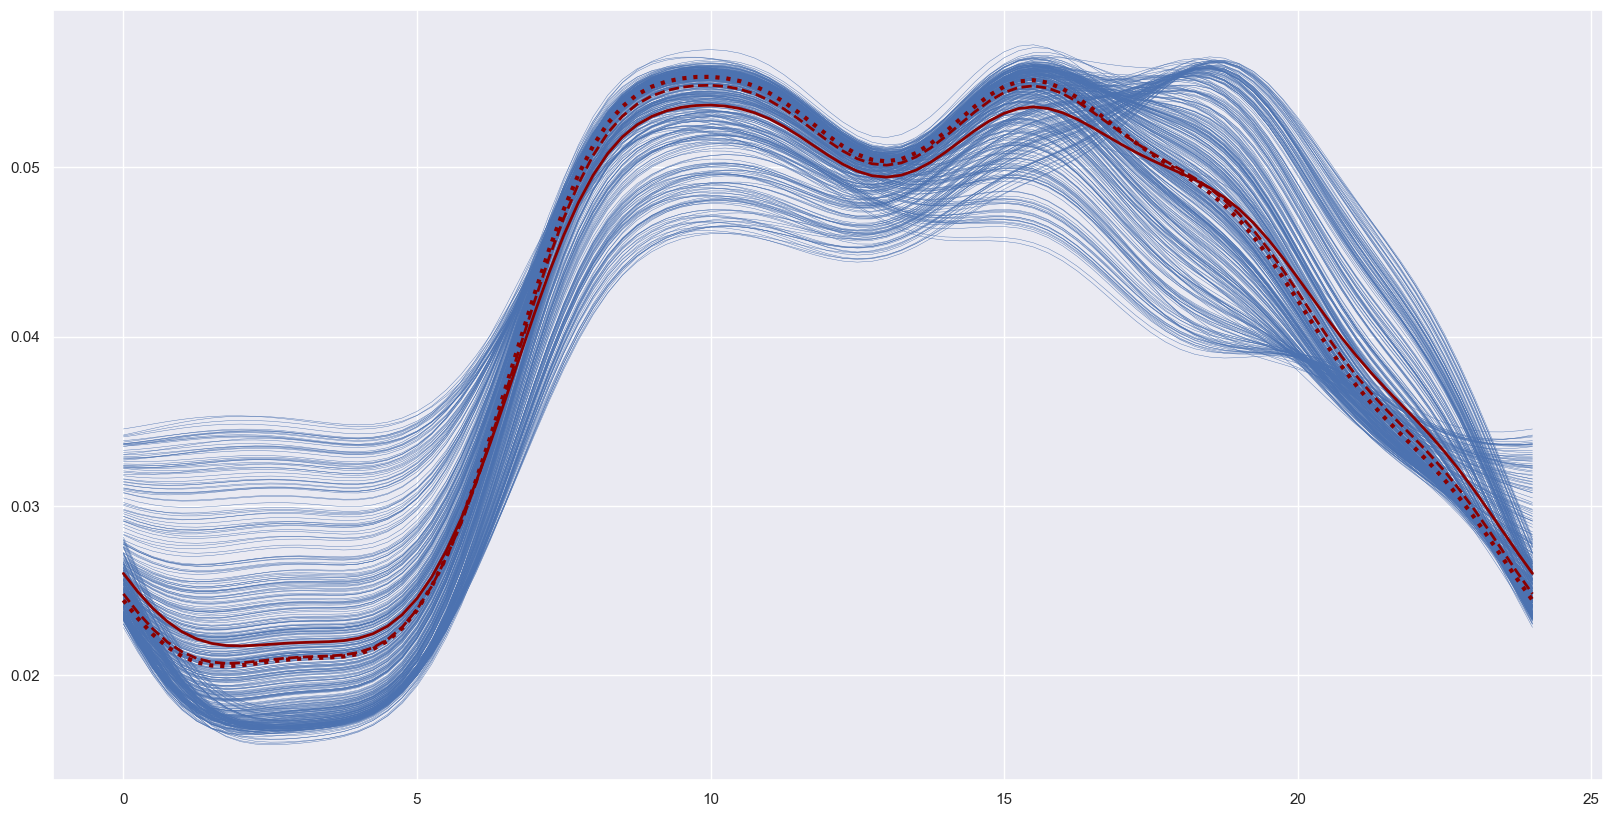

In [259]:
cluster = 0
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    if cluster_label == cluster:
        ax.plot(abscissa, H_results_flat[i, :], linewidth=0.3, color=colors[cluster_label])

# Plot cluster centroids
color = 'darkred'
# color = colors[cluster]
ax.plot(abscissa, kmeans.cluster_centers_[cluster, :], linewidth=2, color=color)
ax.plot(abscissa, geometric_median(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=2, linestyle='dashed', color=color)
ax.plot(abscissa, geometric_medoid(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=3, linestyle='dotted', color=color)
# ax.set_ylim((0,0.05))

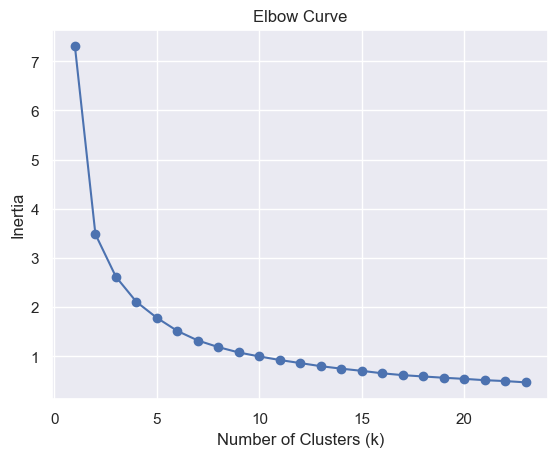

In [202]:
# Seems that there are more than 4 clusters of profiles. Let's try to find how much:

# Calculate inertia for different values of k
inertias = []
k_values = range(1, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

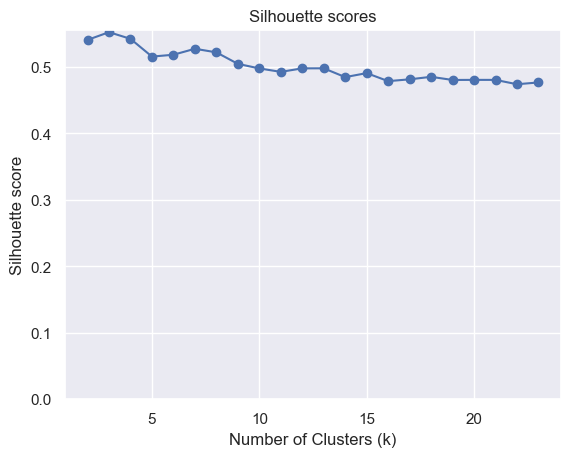

In [177]:
# Calculate silhouette score for different values of k
silhouette_scores = []
k_values = range(2, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    labels = kmeans.labels_
    score = silhouette_score(H_results_flat, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores')
plt.ylim(bottom=0)
plt.show()

<Axes: >

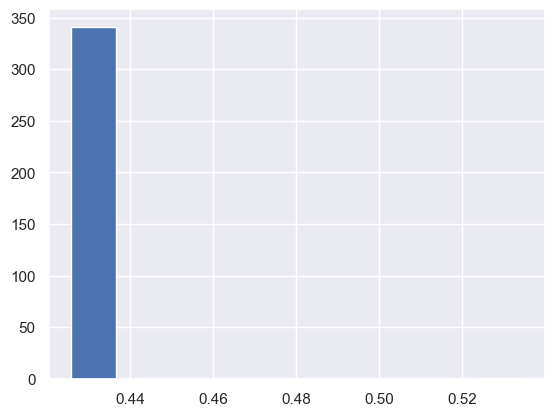

In [261]:
pd.Series(errors / int(X.shape[1] / 24)).hist()

## Select the solution that is compliant to the physics of the problem

### Cyclic profiles

We want to find solutions for which
$$\text{discontinuity}(H) = \sum_{k=1}^K(H_k(p) - H_k(1))^2$$

In [262]:
H_discontinuity = ((H_results[:, 0, :] - H_results[:, p-1, :])**2).sum(axis=0)

<Axes: >

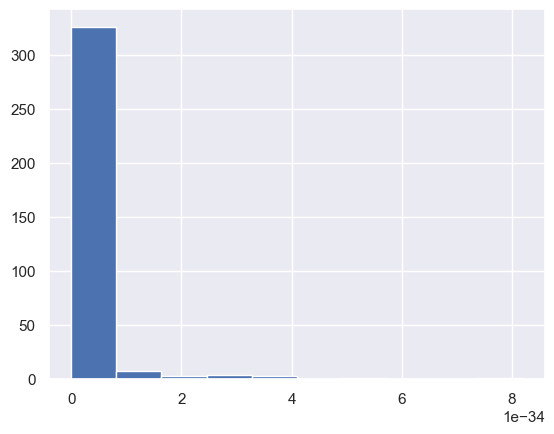

In [263]:
pd.Series(H_discontinuity).hist()

### Total distance of concentration vectors to simplex

The distance to the simplex of one observation $x$ to the simplex $\mathcal{S}(n)$ is the following
$$\text{dist}(x, \mathcal{S}(n)) = \inf_{\substack{y \in \mathcal{S}(n)}} d(x, y)$$

The point $y$ minimizing the distance is:
$$y = \frac{x}{||x||_1}$$

Here we will compute the sum of the distances to the simplex for all vector of concentrations of the matrix $W$

In [264]:
W_proj_simplex = W_results / W_results.sum(axis=1)[:, np.newaxis, :]
W_dist_simplex = np.sqrt(((W_results - W_proj_simplex)**2).sum(axis=1))
W_sum_dist_simplex = W_dist_simplex.sum(axis=0)

<Axes: >

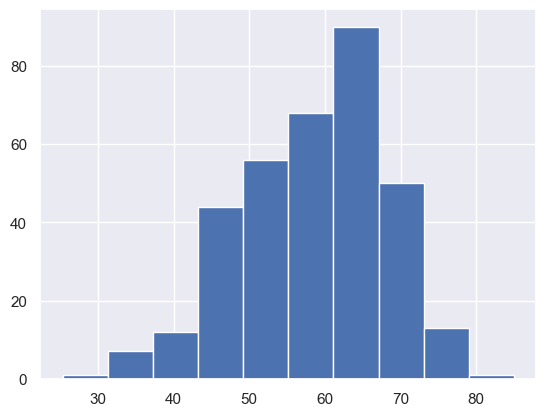

In [265]:
pd.Series(W_sum_dist_simplex).hist()

### Total distance of the components to the p-dimensional simplex

Similarly, the unit l1 norm constraint on the components, having necessarily positive coordinates, result in the components having to lie on the unit 1-sphere

In [266]:
H_proj_unit = int(X.shape[1] / 24) * H_results / H_results.sum(axis=1)[:, np.newaxis, :]
H_dist_unit = np.sqrt(((H_results - H_proj_unit)**2).sum(axis=1) / int(X.shape[1] / 24))
H_sum_dist_unit = H_dist_unit.sum(axis=0)

<Axes: >

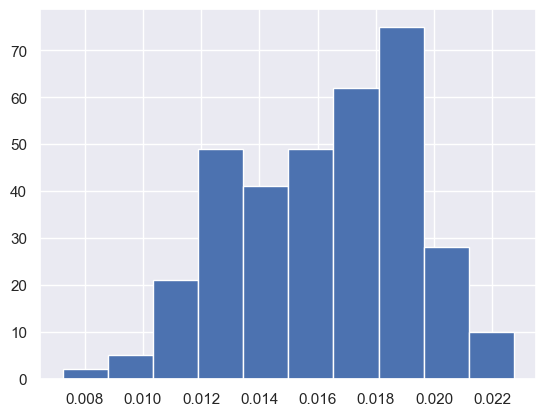

In [267]:
pd.Series(H_sum_dist_unit).hist()

### Scatterplot of the value of the two constraints

In [268]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_discontinuity,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex',
    yaxis_title='Discontinuity of the profiles',
    title='Compliance of solutions with physics of the system',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [269]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_sum_dist_unit,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Sum of distance to the unit sphere for H',
    title='Compliance of solutions with physics of the system',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [270]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=errors / int(X.shape[1] / 24),
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Reconstruction error',
    title='Compliance of solutions with physics of the system and approximation quality',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [271]:
best_run = 324

H = H_results[..., best_run]
W = W_results[..., best_run]

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Components found by the NMF'}, xlabel='Hour', ylabel='Load (MW)'>)

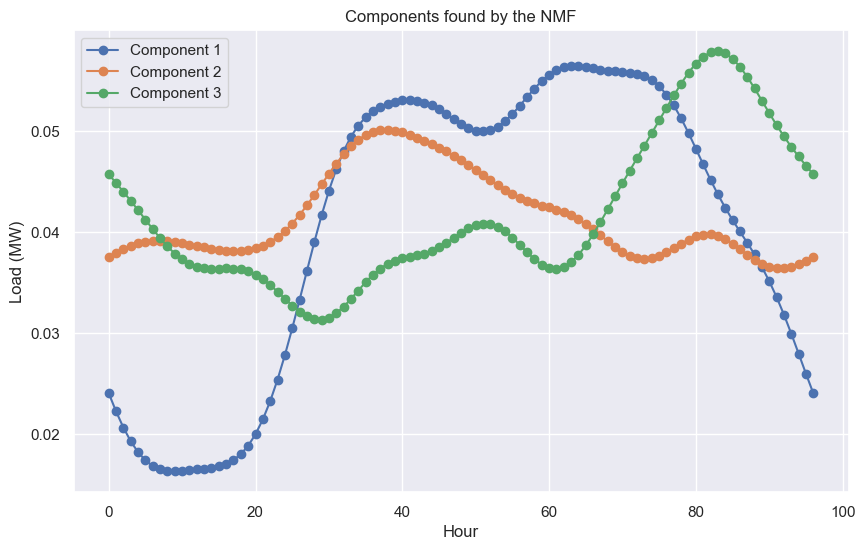

In [272]:
plot_components(H)

In [190]:
W = pd.DataFrame(W, index=df.index, columns=[f"Component {k+1}" for k in range(n_components)])
W[unit_info.columns] = df[unit_info.columns]
W

Component 1  Component 2   Component 3  \
Calabria_2021-01-02_Saturday        0.591734     0.330395  8.343918e-02   
Calabria_2021-01-03_Holiday         0.602022     0.407663  2.104772e-04   
Calabria_2021-01-04_Working day     0.386349     0.586770  3.957506e-02   
Calabria_2021-01-05_Working day     0.251939     0.440483  3.112829e-01   
Calabria_2021-01-06_Holiday         0.462016     0.459592  8.657465e-02   
...                                      ...          ...           ...   
South_2022-12-26_Holiday            0.723701     0.290735  2.649232e-09   
South_2022-12-27_Working day        0.417169     0.593987  2.831267e-03   
South_2022-12-28_Working day        0.303012     0.726546  1.125293e-23   
South_2022-12-29_Working day        0.312552     0.406453  2.846791e-01   
South_2022-12-30_Working day        0.536252     0.481485  1.081835e-06   

                                   region  year month      daytype  
Calabria_2021-01-02_Saturday     Calabria  2021    01     Saturday  
Calabria_2021-01-03_Holiday      Calabria  2021    01      Holiday  
Calabria_2021-01-04_Working day  Calabria  2021    01  Working day  
Calabria_2021-01-05_Working day  Calabria  2021    01  Working day  
Calabria_2021-01-06_Holiday      Calabria  2021    01      Holiday  
...                                   ...   ...   ...          ...  
South_2022-12-26_Holiday            South  2022    12      Holiday  
South_2022-12-27_Working day        South  2022    12  Working day  
South_2022-12-28_Working day        South  2022    12  Working day  
South_2022-12-29_Working day        South  2022    12  Working day  
South_2022-12-30_Working day        South  2022    12  Working day  

[11646 rows x 7 columns]

In [149]:
W[(W.region == 'North')&(W.daytype == 'Working day')].sort_index().tail(20)

Component 1  Component 2  Component 3  \
North_2022-12-01_Working day     0.417532     0.289159     0.045941   
North_2022-12-02_Working day     0.457568     0.302030     0.053264   
North_2022-12-05_Working day     0.470138     0.145099     0.071997   
North_2022-12-06_Working day     0.408785     0.301594     0.041686   
North_2022-12-07_Working day     0.424334     0.318409     0.026727   
North_2022-12-09_Working day     0.413433     0.191057     0.121039   
North_2022-12-12_Working day     0.461799     0.147665     0.067761   
North_2022-12-13_Working day     0.487783     0.261543     0.059409   
North_2022-12-14_Working day     0.464485     0.296691     0.041654   
North_2022-12-15_Working day     0.497883     0.241160     0.084950   
North_2022-12-16_Working day     0.515400     0.299068     0.033764   
North_2022-12-19_Working day     0.478820     0.192105     0.038498   
North_2022-12-20_Working day     0.466134     0.277239     0.052272   
North_2022-12-21_Working day     0.475834     0.282693     0.027409   
North_2022-12-22_Working day     0.480123     0.305851     0.002527   
North_2022-12-23_Working day     0.486617     0.361555     0.001083   
North_2022-12-27_Working day     0.352080     0.151704     0.108998   
North_2022-12-28_Working day     0.349395     0.196619     0.082253   
North_2022-12-29_Working day     0.350353     0.252161     0.079280   
North_2022-12-30_Working day     0.310473     0.230884     0.115576   

                              Component 4 region  year month      daytype  
North_2022-12-01_Working day     0.245930  North  2022    12  Working day  
North_2022-12-02_Working day     0.182660  North  2022    12  Working day  
North_2022-12-05_Working day     0.319883  North  2022    12  Working day  
North_2022-12-06_Working day     0.246022  North  2022    12  Working day  
North_2022-12-07_Working day     0.226965  North  2022    12  Working day  
North_2022-12-09_Working day     0.278417  North  2022    12  Working day  
North_2022-12-12_Working day     0.330420  North  2022    12  Working day  
North_2022-12-13_Working day     0.188673  North  2022    12  Working day  
North_2022-12-14_Working day     0.193722  North  2022    12  Working day  
North_2022-12-15_Working day     0.173164  North  2022    12  Working day  
North_2022-12-16_Working day     0.146514  North  2022    12  Working day  
North_2022-12-19_Working day     0.294857  North  2022    12  Working day  
North_2022-12-20_Working day     0.201757  North  2022    12  Working day  
North_2022-12-21_Working day     0.211751  North  2022    12  Working day  
North_2022-12-22_Working day     0.208483  North  2022    12  Working day  
North_2022-12-23_Working day     0.144036  North  2022    12  Working day  
North_2022-12-27_Working day     0.397074  North  2022    12  Working day  
North_2022-12-28_Working day     0.379683  North  2022    12  Working day  
North_2022-12-29_Working day     0.321238  North  2022    12  Working day  
North_2022-12-30_Working day     0.347953  North  2022    12  Working day

In [150]:
W_region = W.groupby('region')[[f"Component {k+1}" for k in range(n_components)]].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

Component 1  Component 2  Component 3  Component 4
region                                                          
Calabria         0.200050     0.214848     0.269980     0.315122
Centre.North     0.352740     0.212248     0.219781     0.215230
Centre.South     0.250809     0.160033     0.304763     0.284396
North            0.350947     0.268278     0.164767     0.216008
Sardinia         0.236478     0.360543     0.214946     0.188032
Sicily           0.163329     0.256224     0.299143     0.281304
South            0.202689     0.271984     0.260877     0.264450

Text(0, 0.5, '')

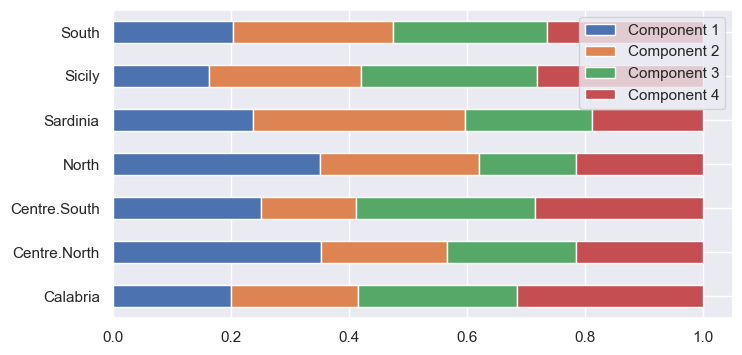

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

<Axes: xlabel='component', ylabel='concentration'>

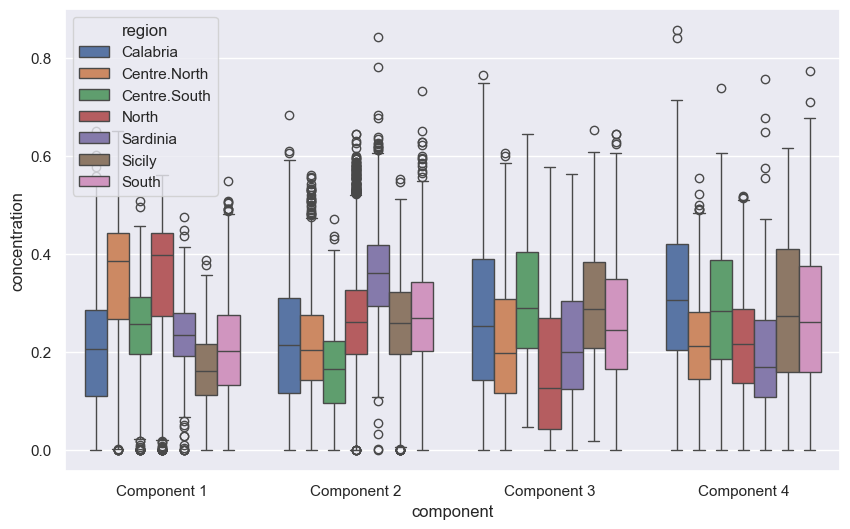

In [152]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='region',
)

<Axes: xlabel='month', ylabel='concentration'>

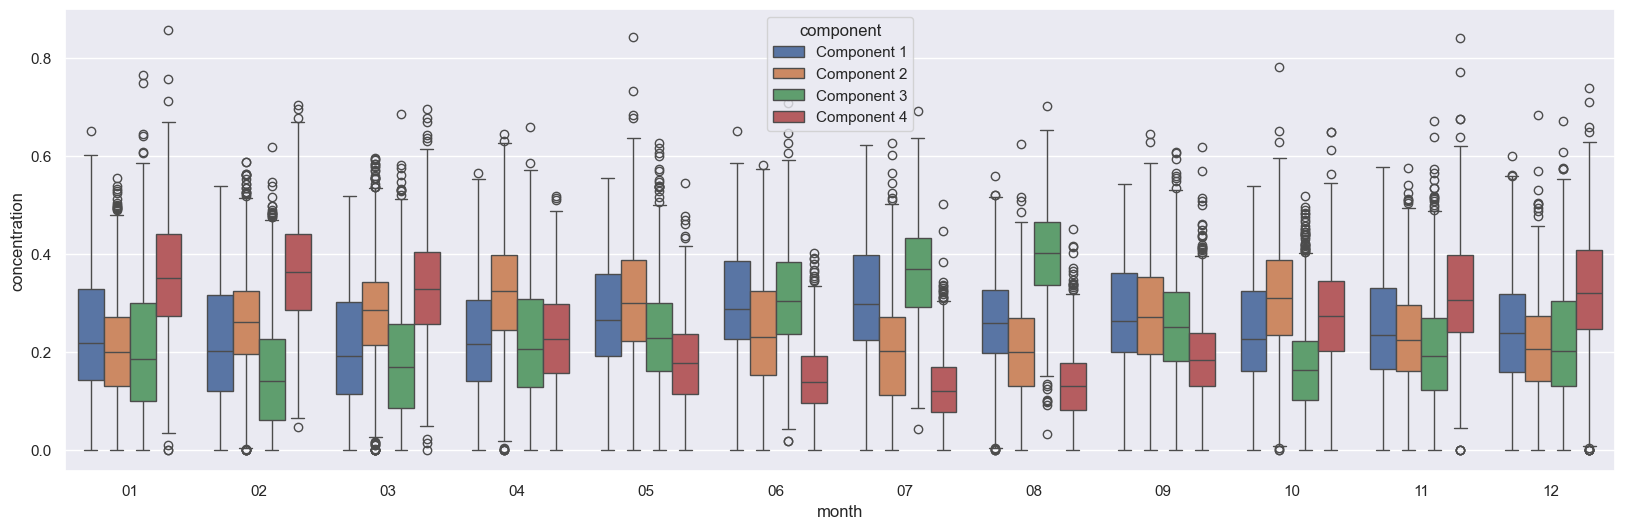

In [153]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

<Axes: xlabel='month', ylabel='concentration'>

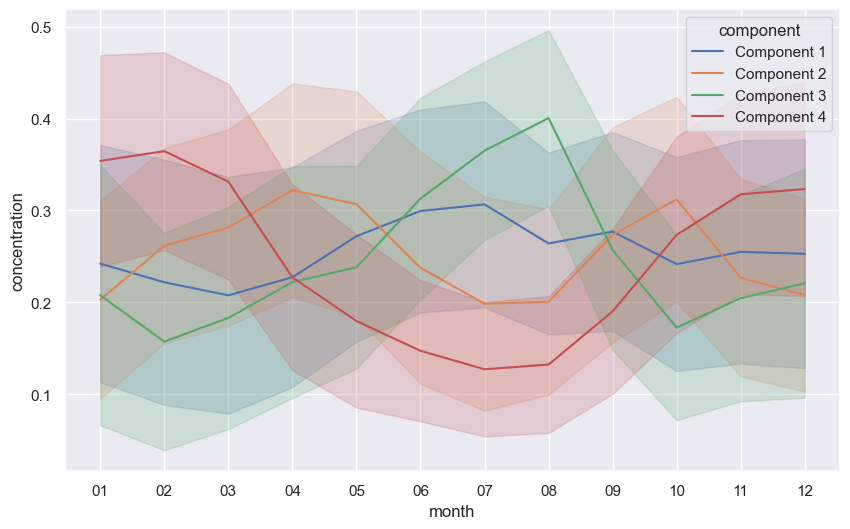

In [154]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

## Save results

In [273]:
if smoothed:
    outfile = f'data/nmf_results/WHopt_{n_components}comp_smoothed_{n_runs}runs.npz'
else:
    outfile = f'data/nmf_results/WHopt_{n_components}comp_{n_runs}runs.npz'
np.savez(outfile, W=W, H=H)
print("Saved results at", outfile)

Saved results at data/nmf_results/WHopt_3comp_smoothed_1000runs.npz


___

# TESTS

In [136]:
n_components_list = [3, 4]

for n_components in n_components_list:

    W_init = initialize_W(X, n_components)
    H_init = np.ones((n_components, p)) / p

    WH_init = np.dot(W_init, H_init)

    # Load the arrays from the .npz file
    data = np.load(f'data/nmf_results/uniform_{n_components}comp.npz')

    iterations = data['iterations']
    H_results = data['H_results'][..., iterations > 100]
    W_results = data['W_results'][..., iterations > 100]

    random_obs = random.randint(0, W_results.shape[2]-1)

    W_random = W_results[..., random_obs]
    H_random = H_results[..., random_obs]

    WH_random = np.dot(W_random, H_random)

    X_fpca = pd.read_csv(f'data/daily_curves_reconstructed_{n_components}PCs.csv', index_col=0)

    # Compute the Frobenius norm between X and the product W_init * H_init
    frobenius_norm_init = np.linalg.norm(X - WH_init, 'fro')
    frobenius_norm_final = np.linalg.norm(X - WH_random, 'fro')
    frobenius_norm_fpca = np.linalg.norm(X - X_fpca, 'fro')

    print(f'### {n_components} components ###')
    print("Frobenius Norm of the initial residual matrix:", frobenius_norm_init)
    print("Frobenius Norm of the final residual matrix:", frobenius_norm_final)
    print("Frobenius Norm of the FPCA residual matrix:", frobenius_norm_fpca)
    print('\n')

### 3 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.949199529377695
Frobenius Norm of the FPCA residual matrix: 0.7711263023212324


### 4 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.7607376211325353
Frobenius Norm of the FPCA residual matrix: 0.6634465209563668




In [36]:
errors[644]

0.6540102320810631

In [37]:
pd.Series(errors).quantile(np.linspace(0, 1, 21))

0.00    0.652081
0.05    0.653201
0.10    0.653387
0.15    0.653528
0.20    0.653644
0.25    0.653732
0.30    0.653810
0.35    0.653886
0.40    0.653961
0.45    0.654024
0.50    0.654114
0.55    0.654191
0.60    0.654272
0.65    0.654357
0.70    0.654444
0.75    0.654533
0.80    0.654648
0.85    0.654759
0.90    0.654923
0.95    0.655146
1.00    0.756661
dtype: float64

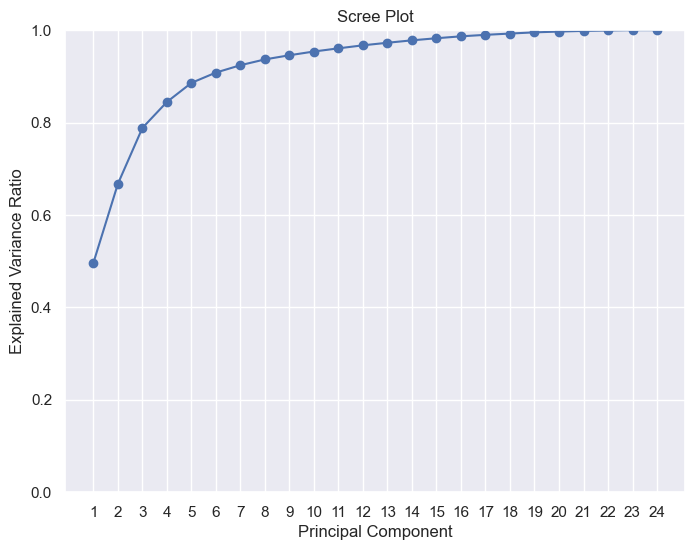

In [74]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
# plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.ylim((0,1))
plt.grid(True)
plt.show()

In [75]:
np.cumsum(pca.explained_variance_ratio_)

array([0.49630093, 0.66741324, 0.78837141, 0.84461045, 0.88591071,
       0.90821743, 0.92415001, 0.93673463, 0.94572021, 0.95382268,
       0.96067938, 0.96721481, 0.97276266, 0.97799972, 0.98254862,
       0.98667156, 0.98989461, 0.99267498, 0.99526384, 0.99697613,
       0.99841413, 0.99930394, 1.        , 1.        ])

In [57]:
# Perform PCA
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X)

In [58]:
pca.n_components_

23